# Задание

Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

Mobile Games AB Testing with Cookie Cats.

In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
df = pd.read_csv('cookie_cats.csv')

In [3]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [5]:
A = df.version.groupby(df.version == 'gate_30').count()
B = df.version.groupby(df.version == 'gate_40').count()
print(A)
print(B)

version
False    45489
True     44700
Name: version, dtype: int64
version
False    44700
True     45489
Name: version, dtype: int64


In [6]:
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

In [7]:
mannwhitneyu(df[df.version == 'gate_30'].sum_gamerounds,
             df[df.version == 'gate_40'].sum_gamerounds)


MannwhitneyuResult(statistic=1024331250.5, pvalue=0.05020880772044255)

pvalue очень блиско к 0.05 соответственно этого теста будит не достаточно для принятия решения.

In [8]:
from scipy.stats import kstest
print(kstest(df['sum_gamerounds'][df.version == 'gate_30'], 'norm'))
print(kstest(df['sum_gamerounds'][df.version == 'gate_40'], 'norm'))

KstestResult(statistic=0.8724176532867202, pvalue=0.0, statistic_location=2, statistic_sign=-1)
KstestResult(statistic=0.8707186187388001, pvalue=0.0, statistic_location=2, statistic_sign=-1)


Text(0.5, 1.0, 'Number of game rounds players on the first week')

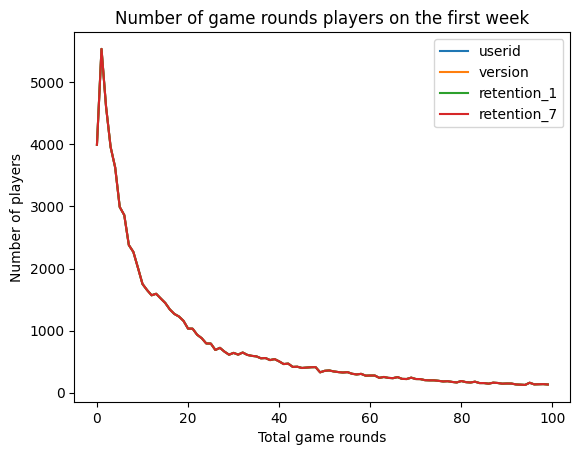

In [9]:
# играющие пользователи
plot_df = df.groupby('sum_gamerounds').count()

ax = plot_df[:100].plot()
ax.set_xlabel('Total game rounds')
ax.set_ylabel('Number of players')
ax.set_title('Number of game rounds players on the first week')

График показывает, что большенство пользователей играет менее 20 раундов.

Построим гистограммный график различных распределений групп AB.

Чтобы получить более детальное представление о низкой и высокой активности пользователей изменим наше распределение выборок.

In [10]:
plt.style.use('ggplot')

Group_A = df[df.version == 'gate_30']
print(Group_A.head())

Group_B = df[df.version == 'gate_40']
print(Group_B.head())

bins = [0, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 500]
plot_GA = pd.DataFrame(Group_A.groupby(pd.cut(Group_A['sum_gamerounds'],
                                              bins=bins)).count())
plot_GB = pd.DataFrame(Group_B.groupby(pd.cut(Group_B['sum_gamerounds'],
                                              bins=bins)).count())

    userid  version  sum_gamerounds  retention_1  retention_7
0      116  gate_30               3        False        False
1      337  gate_30              38         True        False
6     1066  gate_30               0        False        False
11    2101  gate_30               0        False        False
13    2179  gate_30              39         True        False
   userid  version  sum_gamerounds  retention_1  retention_7
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True
5     540  gate_40             187         True         True
7    1444  gate_40               2        False        False


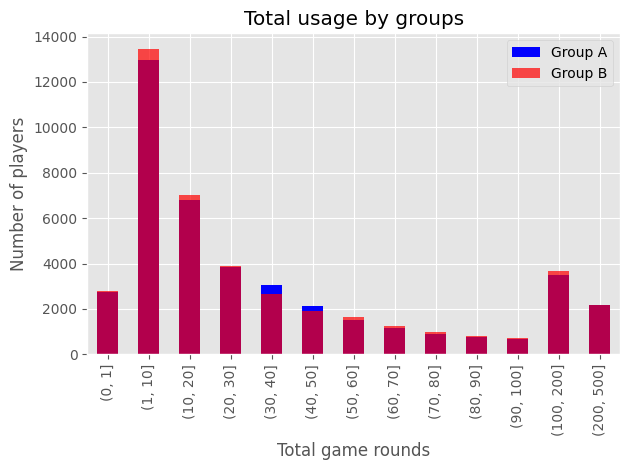

In [11]:
ax = plot_GA.plot(kind = 'bar', y='userid', color = 'blue', alpha = 1,
                  title = 'Total usage by groups')
plot_GB.plot(kind = 'bar', y = 'userid', ax = ax, color = 'red', alpha = 0.7)
ax.set_xlabel('Total game rounds')
ax.set_ylabel('Number of players')
plt.legend(['Group A', 'Group B'])
plt.tight_layout()
plt.grid(True)

In [12]:
day1 = df.retention_1.sum()/df.retention_1.count()
print(str(day1*100)+'%')
     

44.52095044850259%


In [13]:
day1 = df.retention_1.groupby(df.version).sum()/df.retention_1.groupby(df.version).count()
print(day1*100)

version
gate_30    44.818792
gate_40    44.228275
Name: retention_1, dtype: float64


In [14]:
boot_1d = []
for i in range(500):
  boot_mean = df.retention_1.sample(frac=1, replace=True).groupby(df.version).mean()
  boot_1d.append(boot_mean)

boot_1d = pd.DataFrame(boot_1d)
print(boot_1d)

version       gate_30   gate_40
retention_1  0.446717  0.442617
retention_1  0.449683  0.442634
retention_1  0.452763  0.439496
retention_1  0.447961  0.441846
retention_1  0.445753  0.440207
...               ...       ...
retention_1  0.446092  0.439581
retention_1  0.449906  0.442007
retention_1  0.446836  0.439867
retention_1  0.444752  0.440702
retention_1  0.446273  0.445285

[500 rows x 2 columns]


Text(0.5, 0, 'The average of 1-day retention')

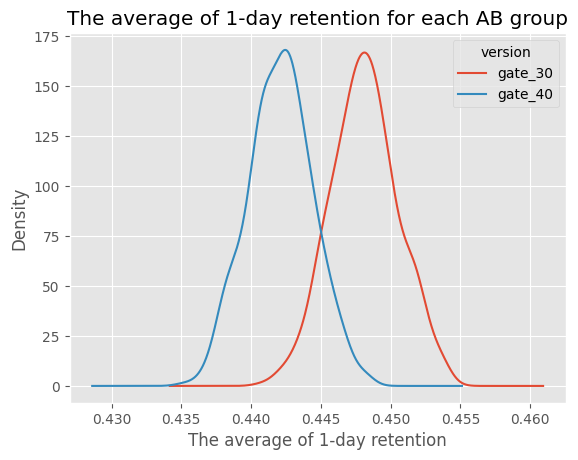

In [15]:
ax = boot_1d.plot.kde()
ax.set_title('The average of 1-day retention for each AB group')
ax.set_xlabel('The average of 1-day retention')

Text(0.5, 1.0, 'Zooming % difference')

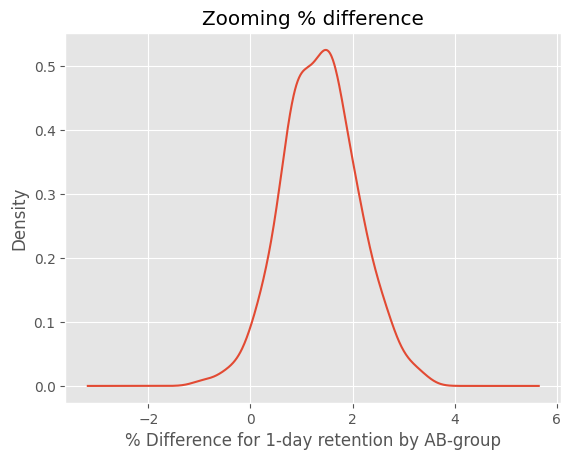

In [16]:
boot_1d['difference'] = (boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40']*100

ax = boot_1d['difference'].plot.kde()
ax.set_xlabel('% Difference for 1-day retention by AB-group')
ax.set_title('Zooming % difference')

Из графика видно, что наиболее вероятная разница 1-2% в пользу ворот на 30 уровне.

Посчитаем в скольки процентах случаев разница больше 0.

In [17]:
prob = (boot_1d['difference'] > 0).sum() / len(boot_1d['difference'])
print(str(prob*100)+'%')

97.0%


Вывод:
Существует высокая вероятность того, что удержание в течении 1 дня лучше, когда ворота находятся на уровне 30.

Следовательно для удержания аудитории не рекомендуется перемещать варота с 30 уровня на 40.